## Description about this notebook
This notebook is designed to visually compare the performance of our three different YOLO NAS models (Small, Medium, Large) in terms of two key metrics: Mean Average Precision at 50% (MAP50) and Mean Average Precision from 50% to 95% (MAP50:95). We employed a supervision function for this evaluation. The assessment was carried out on a test dataset, which was not previously exposed to the models. This test dataset is unique as it comprises a new blend of Jersey and Holstein cow images, captured from two distinct camera perspectives: top and side views. This setup ensures a comprehensive evaluation of the models' ability to accurately detect and recognize objects in varied and realistic scenarios.

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
import logging

# Set logging level to WARNING to ignore INFO messages
logging.basicConfig(level=logging.WARNING)


from ultralytics import NAS
os.chdir("..")
ROOT = os.getcwd()
print(ROOT)


/Users/mautushid/github/Cowsformer


In [2]:
from models.nas import *
import pandas as pd
import matplotlib.pyplot as plt

The console stream is logged into /Users/mautushid/sg_logs/console.log


[2024-02-11 22:15:26] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-11 22:15:27] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-02-11 22:15:27] WARNING - redirects.py - NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-02-11 22:15:31] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-11 22:15:31] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-11 22:15:31] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2024-02-11 22:15:31] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [3]:


# Make sure ROOT is defined correctly to point to the directory containing 'old_checkpoints'
#ROOT = '/path/to/your/root/directory'
checkpoints_dir = os.path.join(ROOT, "old_checkpoints")

def organize_ckpt_paths(checkpoints_dir):
    organized_paths = {}

    # Walk through the checkpoints directory
    for folder in os.listdir(checkpoints_dir):
        folder_path = os.path.join(checkpoints_dir, folder)
        
        # Make sure it's a directory and not a file
        if os.path.isdir(folder_path):
            # Extract the size and model size from the folder name
            parts = folder.split('_')
            if len(parts) > 3:  # Check for the expected number of parts
                size = parts[0]  # e.g., 'n100'
                model_size = parts[-3][-1]  # e.g., 's', 'm', 'l'

                # Validate that we have the correct model size identifier
                if model_size in ['s', 'm', 'l']:
                    ckpt_path = os.path.join(folder_path, 'ckpt_best.pth')
                    # Check if the checkpoint file exists
                    if os.path.exists(ckpt_path):
                        # Initialize nested dictionaries if not present
                        if size not in organized_paths:
                            organized_paths[size] = {'s': [], 'm': [], 'l': []}
                        organized_paths[size][model_size].append(ckpt_path)

    # Sort the paths
    for size in organized_paths:
        for model_size in organized_paths[size]:
            organized_paths[size][model_size].sort()

    return organized_paths

# Get the organized paths
organized_paths = organize_ckpt_paths(checkpoints_dir)

# Print the organized paths
for size, model_sizes in organized_paths.items():
    print(f"{size}:")
    for model_size, paths in model_sizes.items():
        print(f"  {model_size}:")
        for path in paths:
            print(f"    {path}")


In [4]:
organized_paths

{'n10': {'s': ['/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_s_10_1/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_s_10_2/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_s_10_3/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_s_10_4/ckpt_best.pth'],
  'm': ['/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_m_10_1/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_m_10_2/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_m_10_3/ckpt_best.pth',
   '/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_m_10_4/ckpt_best.pth'],
  'l': ['/Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_l_10_1/ckpt_best.pth',
   '/Users/mautushid/g

In [5]:
n10_s_path = organized_paths['n10']['s']
n10_m_path = organized_paths['n10']['m']
n10_l_path = organized_paths['n10']['l']

n25_s_path = organized_paths['n200']['s']
n25_m_path = organized_paths['n200']['m']
n25_l_path = organized_paths['n200']['l']

n50_s_path = organized_paths['n200']['s']
n50_m_path = organized_paths['n200']['m']
n50_l_path = organized_paths['n200']['l']

n100_s_path = organized_paths['n200']['s']
n100_m_path = organized_paths['n200']['m']
n100_l_path = organized_paths['n200']['l']

n200_s_path = organized_paths['n200']['s']
n200_m_path = organized_paths['n200']['m']
n200_l_path = organized_paths['n200']['l']

In [6]:
path_model_s = 'yolo_nas_s'
path_model_m = 'yolo_nas_m'
path_model_l = 'yolo_nas_l'
dir_train = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/train"
dir_val = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/val"
dir_test = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/test_old"
name_task = "cow200"
data_yaml_path = "/Users/mautushid/github/Cowsformer/data/cow200/yolov5/data.yaml"

def evaluate_models_s(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_s, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_s, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_m(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_m, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_m, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

def evaluate_models_l(finetuned_model_paths):
    models = []
    evaluation_results = []
    my_nas = Niche_YOLO_NAS(path_model_l, dir_train, dir_val, dir_test, name_task)
    
    # Load models
    for path in finetuned_model_paths:
        model = my_nas.load(path_model_l, path)
        models.append(model)
    
    # Evaluate models
    for model in models:
        metrics = my_nas.get_map_scores(model, data_yaml_path, "test")
        evaluation_results.append(metrics)
    
    return evaluation_results

In [7]:
evaluattion_results_n10_s_path = evaluate_models_s(n10_s_path)
evaluattion_results_n10_m_path = evaluate_models_m(n10_m_path)
evaluattion_results_n10_l_path = evaluate_models_l(n10_l_path)

evaluattion_results_n25_s_path = evaluate_models_s(n25_s_path)
evaluattion_results_n25_m_path = evaluate_models_m(n25_m_path)
evaluattion_results_n25_l_path = evaluate_models_l(n25_l_path)

evaluattion_results_n50_s_path = evaluate_models_s(n50_s_path)
evaluattion_results_n50_m_path = evaluate_models_m(n50_m_path)
evaluattion_results_n50_l_path = evaluate_models_l(n50_l_path)

evaluattion_results_n100_s_path = evaluate_models_s(n100_s_path)
evaluattion_results_n100_m_path = evaluate_models_m(n100_m_path)
evaluattion_results_n100_l_path = evaluate_models_l(n100_l_path)

evaluattion_results_n200_s_path = evaluate_models_s(n200_s_path)
evaluattion_results_n200_m_path = evaluate_models_m(n200_m_path)
evaluattion_results_n200_l_path = evaluate_models_l(n200_l_path)

[2024-02-11 22:15:31] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


n10:
  s:
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_s_10_1/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_s_10_2/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_s_10_3/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_s_10_4/ckpt_best.pth
  m:
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_m_10_1/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_m_10_2/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_m_10_3/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_m_10_4/ckpt_best.pth
  l:
    /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_l_10_1/ckpt_best.pth
    /Users/mautushid/github/Cowsformer/old_c

[2024-02-11 22:15:31] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-11 22:15:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i1_exp_yolo_nas_s_10_1/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:15:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_s_10_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:15:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_s_10_3/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:15:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_s_10_4/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:15:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 22:15:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:15:35] INFO -

model yolo_nas_m loaded


[2024-02-11 22:16:15] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_m_10_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:16:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_m_10_3/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:16:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_m_10_4/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:16:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 22:16:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:16:19] INFO -

model yolo_nas_l loaded


[2024-02-11 22:17:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i2_exp_yolo_nas_l_10_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:17:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i3_exp_yolo_nas_l_10_3/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:17:19] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n10_yolo_na_i4_exp_yolo_nas_l_10_4/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:17:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 22:17:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:20] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:21] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:17:22] INFO -

model yolo_nas_s loaded


[2024-02-11 22:18:32] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:18:33] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:18:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 22:18:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:34] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:18:34] INFO -

model yolo_nas_m loaded


[2024-02-11 22:19:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:19:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:19:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 22:19:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:06] INFO -

model yolo_nas_l loaded


[2024-02-11 22:19:50] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:19:51] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:19:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 22:19:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:19:54] INFO -

model yolo_nas_s loaded


[2024-02-11 22:20:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:20:47] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:20:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 22:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:48] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:49] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:20:49] INFO -

model yolo_nas_m loaded


[2024-02-11 22:21:16] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:21:17] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:21:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 22:21:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:21:20] INFO -

model yolo_nas_l loaded


[2024-02-11 22:22:02] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:22:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:22:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 22:22:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:04] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:06] INFO -

model yolo_nas_s loaded


[2024-02-11 22:22:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:22:59] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:22:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 22:22:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:22:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:00] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:00] INFO -

model yolo_nas_m loaded


[2024-02-11 22:23:28] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:23:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:23:29] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 22:23:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:23:31] INFO -

model yolo_nas_l loaded


[2024-02-11 22:24:13] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:24:14] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 22:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:15] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:16] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:24:17] INFO -

model yolo_nas_s loaded


[2024-02-11 22:25:11] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_s_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_s loaded


[2024-02-11 22:25:12] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_s_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:25:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_s loaded


[2024-02-11 22:25:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:12] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:13] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:13] INFO -

model yolo_nas_m loaded


[2024-02-11 22:25:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_m_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_m loaded


[2024-02-11 22:25:43] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_m_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:25:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_m loaded


[2024-02-11 22:25:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:44] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:45] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:25:46] INFO -

model yolo_nas_l loaded


[2024-02-11 22:26:29] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i2_exp_yolo_nas_l_200_2/ckpt_best.pth EMA checkpoint.


model yolo_nas_l loaded


[2024-02-11 22:26:30] INFO - checkpoint_utils.py - Successfully loaded model weights from /Users/mautushid/github/Cowsformer/old_checkpoints/n200_yolo_na_i3_exp_yolo_nas_l_200_3/ckpt_best.pth EMA checkpoint.
[2024-02-11 22:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


model yolo_nas_l loaded


[2024-02-11 22:26:30] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:32] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:33] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-02-11 22:26:33] INFO -

In [8]:
evaluattion_results_n10_s_path

[{'mAP@50': 0.9021578136283942, 'mAP@50:95': 0.6370249996788668},
 {'mAP@50': 0.9207467111857732, 'mAP@50:95': 0.6430050896195819},
 {'mAP@50': 0.9101831646473447, 'mAP@50:95': 0.6467625115644433},
 {'mAP@50': 0.904938457229781, 'mAP@50:95': 0.642640142892392}]

In [9]:
evaluattion_results_n10_m_path

[{'mAP@50': 0.9537708837249201, 'mAP@50:95': 0.7079125438391795},
 {'mAP@50': 0.9416455826690889, 'mAP@50:95': 0.6902442325072219},
 {'mAP@50': 0.9558591906021517, 'mAP@50:95': 0.7015138548539142},
 {'mAP@50': 0.9477797942118288, 'mAP@50:95': 0.6992834087442488}]

In [10]:
evaluattion_results_n10_l_path

[{'mAP@50': 0.9544661618737074, 'mAP@50:95': 0.7176332566952242},
 {'mAP@50': 0.9412631837585286, 'mAP@50:95': 0.7122742242902858},
 {'mAP@50': 0.9518007567024663, 'mAP@50:95': 0.7190513741570632},
 {'mAP@50': 0.9575403163167524, 'mAP@50:95': 0.7236762371217473}]

In [11]:
evaluattion_results_n200_s_path

[{'mAP@50': 0.9058707455794132, 'mAP@50:95': 0.6366251914934974},
 {'mAP@50': 0.9149165831001779, 'mAP@50:95': 0.6474163671852695},
 {'mAP@50': 0.8998279870240248, 'mAP@50:95': 0.630396887198722}]

In [12]:
evaluattion_results_n200_m_path

[{'mAP@50': 0.9410965858978262, 'mAP@50:95': 0.6928265133876826},
 {'mAP@50': 0.9474738623130992, 'mAP@50:95': 0.7113717062670769},
 {'mAP@50': 0.9497204717513764, 'mAP@50:95': 0.7116792188839918}]

In [13]:
evaluattion_results_n200_l_path

[{'mAP@50': 0.9491001912194094, 'mAP@50:95': 0.7139276777301194},
 {'mAP@50': 0.9536788814913979, 'mAP@50:95': 0.6990511546719611},
 {'mAP@50': 0.9502735429910493, 'mAP@50:95': 0.692754507608693}]

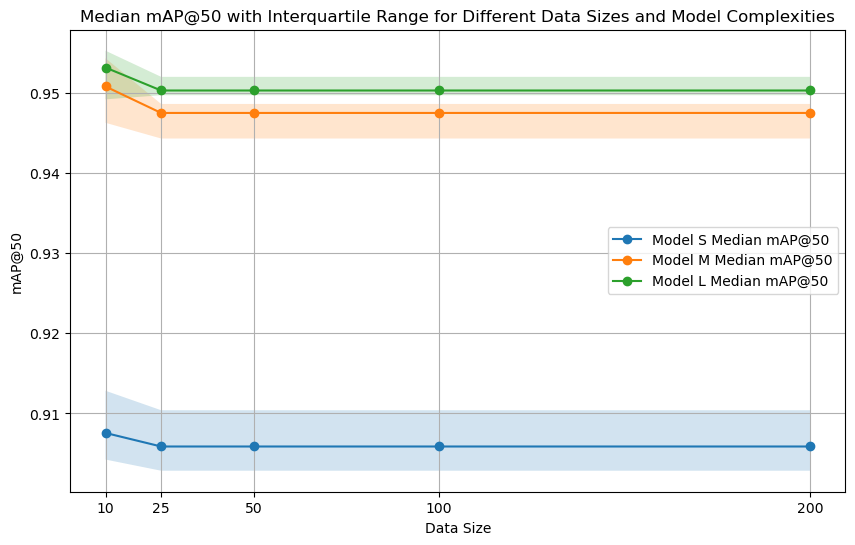

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual evaluation data in these variables
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    median_map50 = np.median(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'median': median_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the median values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    median_values = [evaluation_statistics[key]['median'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the median line
    ax.plot(data_sizes, median_values, marker='o', label=f'Model {model_size.upper()} Median mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Median mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()


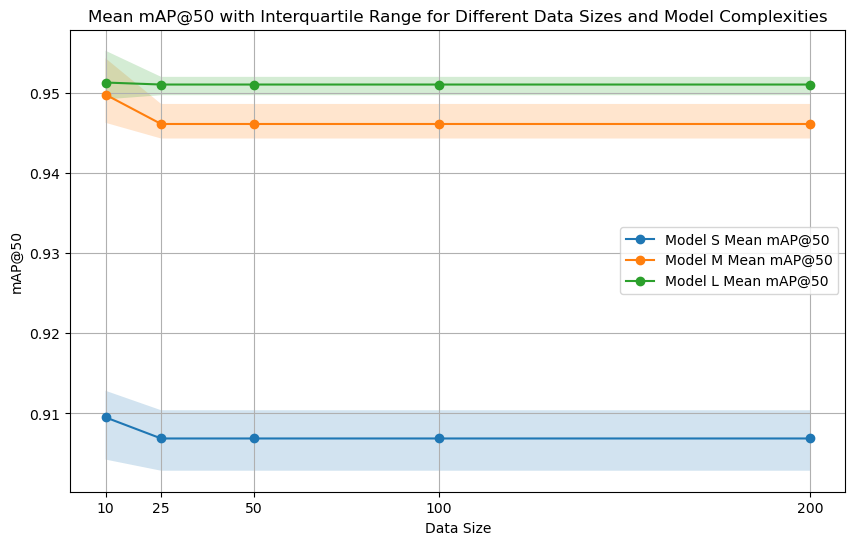

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the actual evaluation data in these variables
# Replace these lines with your actual evaluation data
evaluation_results_n10_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n10_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n25_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n100_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n50_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_s_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_m_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]
evaluation_results_n200_l_path = [{'mAP@50': np.random.uniform(0.4, 0.8)} for _ in range(8)]



# Collect all the results in a dictionary for processing
evaluation_results = {
    'n10_s': evaluattion_results_n10_s_path,
    'n10_m': evaluattion_results_n10_m_path,
    'n10_l': evaluattion_results_n10_l_path,
    'n25_s': evaluattion_results_n25_s_path,
    'n25_m': evaluattion_results_n25_m_path,
    'n25_l': evaluattion_results_n25_l_path,
    'n50_s': evaluattion_results_n50_s_path,
    'n50_m': evaluattion_results_n50_m_path,
    'n50_l': evaluattion_results_n50_l_path,
    'n100_s': evaluattion_results_n100_s_path,
    'n100_m': evaluattion_results_n100_m_path,
    'n100_l': evaluattion_results_n100_l_path,
    'n200_s': evaluattion_results_n200_s_path,
    'n200_m': evaluattion_results_n200_m_path,
    'n200_l': evaluattion_results_n200_l_path,
    
}

# Calculate statistics for each combination of dataset size and model complexity
evaluation_statistics = {}
for key, results in evaluation_results.items():
    map50_scores = [res['mAP@50'] for res in results]
    mean_map50 = np.mean(map50_scores)
    q1_map50 = np.percentile(map50_scores, 25)
    q3_map50 = np.percentile(map50_scores, 75)
    
    evaluation_statistics[key] = {
        'mean': mean_map50,
        'q1': q1_map50,
        'q3': q3_map50
    }

# Sort the keys to make sure the data sizes are in order (from smallest to largest dataset size)
sorted_keys = sorted(evaluation_statistics, key=lambda x: (int(x[1:x.index('_')]), x[-1]))

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean values and fill the area between Q1 and Q3
for model_size in ['s', 'm', 'l']:  # For each model size
    data_sizes = [int(key[1:key.index('_')]) for key in sorted_keys if key.endswith(model_size)]
    mean_values = [evaluation_statistics[key]['mean'] for key in sorted_keys if key.endswith(model_size)]
    q1_values = [evaluation_statistics[key]['q1'] for key in sorted_keys if key.endswith(model_size)]
    q3_values = [evaluation_statistics[key]['q3'] for key in sorted_keys if key.endswith(model_size)]

    # Plot the mean line
    ax.plot(data_sizes, mean_values, marker='o', label=f'Model {model_size.upper()} Mean mAP@50')
    
    # Fill the area between Q1 and Q3 for the interquartile range
    ax.fill_between(data_sizes, q1_values, q3_values, alpha=0.2)

# Customize the plot
ax.set_title('Mean mAP@50 with Interquartile Range for Different Data Sizes and Model Complexities')
ax.set_xlabel('Data Size')
ax.set_ylabel('mAP@50')
ax.set_xticks(sorted(set(data_sizes))) # Set x-ticks to unique sorted data sizes
ax.legend()
ax.grid(True)

# Show the plot
plt.show()
